# Scenario -> condensed config training with Random Forest Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
RSEED = 50

## Load tables and clean data

In [2]:
with open("oracle_k_10_policy.pq", 'rb') as f:
    scenario_config_policy = pickle.load(f)

In [3]:
label_list, label_indices = np.unique(list(scenario_config_policy.values()), return_inverse=True)

In [4]:
scenario_label_df = pd.DataFrame([{"run": r, "label_index": li} for (r, li) in zip(scenario_config_policy.keys(), label_indices)])
scenario_label_df

,run,label_index
0,training_0000-S0,11
1,training_0000-S1,6
2,training_0000-S10,11
3,training_0000-S11,18
4,training_0000-S12,2
...,...,...
143,training_0005-S5,6
144,training_0005-S6,11
145,training_0005-S7,17
146,training_0005-S8,17


In [5]:
scenario_feats_df = pd.read_csv("../data/scenario_features_v2.csv")
scenario_feats_df

,Unnamed: 0,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,weather,location,scenario_name
0,0,53.444444,80.2,6.0,247.234697,8954.720055,2.417085,101.993745,3410.922277,8.827853,Day,sunny,location_sf,training_0004-S_24
1,1,117.961538,197.0,20.0,131.738267,38093.553801,15.568528,60.189865,24916.815591,1.613907,Day,sunny,location_sf,training_0004-S_14
2,2,64.694444,156.0,25.0,51.889146,8095.026669,11.703518,28.880993,3753.227900,18.223584,Day,sunny,location_phx,training_0004-S_0
3,3,45.413043,67.0,21.0,107.360995,4593.823205,10.550505,72.368302,2318.215522,12.334894,Day,sunny,location_phx,training_0004-S_23
4,4,121.321429,197.0,73.0,28.401004,12588.225953,68.974619,12.779036,10279.801052,1.585742,Day,sunny,location_sf,training_0004-S_13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,143,30.791667,54.7,8.0,472.672033,155746.596694,3.713568,170.250245,60098.840417,2.458020,Day,sunny,location_sf,training_0001-S_15
144,144,150.954545,199.0,20.0,31.987256,6475.869405,16.688442,19.789628,3907.838562,5.888482,Day,sunny,location_phx,training_0001-S_5
145,145,66.637363,165.0,40.2,52.452393,8235.238310,30.472362,35.758511,6157.662639,28.623804,Day,sunny,location_phx,training_0001-S_22
146,146,83.633333,159.3,18.0,67.911989,13281.949758,12.671717,42.263428,7677.699864,10.682600,Day,sunny,location_phx,training_0001-S_12


In [6]:
scenario_feats_df = scenario_feats_df.loc[:, ~scenario_feats_df.columns.str.contains('^Unnamed')]
scenario_feats_df = scenario_feats_df.drop(columns=["weather"])  # weather column is all the same
scenario_feats_df["scenario_name"] = scenario_feats_df["scenario_name"].apply(lambda x: x.replace("-S_", "-S"))
scenario_feats_df

,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,location,scenario_name
0,53.444444,80.2,6.0,247.234697,8954.720055,2.417085,101.993745,3410.922277,8.827853,Day,location_sf,training_0004-S24
1,117.961538,197.0,20.0,131.738267,38093.553801,15.568528,60.189865,24916.815591,1.613907,Day,location_sf,training_0004-S14
2,64.694444,156.0,25.0,51.889146,8095.026669,11.703518,28.880993,3753.227900,18.223584,Day,location_phx,training_0004-S0
3,45.413043,67.0,21.0,107.360995,4593.823205,10.550505,72.368302,2318.215522,12.334894,Day,location_phx,training_0004-S23
4,121.321429,197.0,73.0,28.401004,12588.225953,68.974619,12.779036,10279.801052,1.585742,Day,location_sf,training_0004-S13
...,...,...,...,...,...,...,...,...,...,...,...,...
143,30.791667,54.7,8.0,472.672033,155746.596694,3.713568,170.250245,60098.840417,2.458020,Day,location_sf,training_0001-S15
144,150.954545,199.0,20.0,31.987256,6475.869405,16.688442,19.789628,3907.838562,5.888482,Day,location_phx,training_0001-S5
145,66.637363,165.0,40.2,52.452393,8235.238310,30.472362,35.758511,6157.662639,28.623804,Day,location_phx,training_0001-S22
146,83.633333,159.3,18.0,67.911989,13281.949758,12.671717,42.263428,7677.699864,10.682600,Day,location_phx,training_0001-S12


In [7]:
from functools import reduce
scenario_feats_df = scenario_feats_df[
    reduce(lambda x, y: x&y, [~scenario_feats_df["scenario_name"].str.contains("training_000{}".format(x)) for x in [6, 7, 8, 9]])
]
scenario_feats_df

,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,location,scenario_name
0,53.444444,80.2,6.0,247.234697,8954.720055,2.417085,101.993745,3410.922277,8.827853,Day,location_sf,training_0004-S24
1,117.961538,197.0,20.0,131.738267,38093.553801,15.568528,60.189865,24916.815591,1.613907,Day,location_sf,training_0004-S14
2,64.694444,156.0,25.0,51.889146,8095.026669,11.703518,28.880993,3753.227900,18.223584,Day,location_phx,training_0004-S0
3,45.413043,67.0,21.0,107.360995,4593.823205,10.550505,72.368302,2318.215522,12.334894,Day,location_phx,training_0004-S23
4,121.321429,197.0,73.0,28.401004,12588.225953,68.974619,12.779036,10279.801052,1.585742,Day,location_sf,training_0004-S13
...,...,...,...,...,...,...,...,...,...,...,...,...
143,30.791667,54.7,8.0,472.672033,155746.596694,3.713568,170.250245,60098.840417,2.458020,Day,location_sf,training_0001-S15
144,150.954545,199.0,20.0,31.987256,6475.869405,16.688442,19.789628,3907.838562,5.888482,Day,location_phx,training_0001-S5
145,66.637363,165.0,40.2,52.452393,8235.238310,30.472362,35.758511,6157.662639,28.623804,Day,location_phx,training_0001-S22
146,83.633333,159.3,18.0,67.911989,13281.949758,12.671717,42.263428,7677.699864,10.682600,Day,location_phx,training_0001-S12


### Join tables, one-hot encode

In [8]:
x = set(scenario_label_df["run"])
y = set(scenario_feats_df["scenario_name"])
x.difference(y), y.difference(x)

(set(), set())

In [9]:
joined_df = scenario_label_df.set_index('run').join(scenario_feats_df.set_index('scenario_name'), lsuffix="_config_df", rsuffix="_scenario_df", how="inner")
assert not joined_df.isnull().values.any(), "Some values are Nan after join, it means some scenarios in config_df don't show up in scenario_df"
assert not joined_df.isna().values.any(), "Some values are Nan after join, it means some scenarios in config_df don't show up in scenario_df"
joined_df

,label_index,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,location
training_0000-S0,11,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,Day,location_sf
training_0000-S1,6,103.259259,175.0,50.0,49.616457,46870.875085,42.030151,30.518480,52875.208306,0.383722,Day,location_sf
training_0000-S10,11,56.454545,105.0,4.0,76.439390,38357.517547,3.120603,41.192411,17850.350271,4.144654,Dawn/Dusk,location_sf
training_0000-S11,18,53.425000,99.6,38.0,41.488826,2842.560143,32.378788,33.613229,2000.154715,19.094199,Day,location_phx
training_0000-S12,2,45.666667,126.0,8.0,185.012790,26528.361155,4.843434,69.958587,8737.199796,8.112840,Night,location_phx
...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S5,6,109.058824,196.0,66.0,41.705050,16720.338659,56.181818,28.324301,12040.445311,0.723443,Day,location_sf
training_0005-S6,11,67.866667,139.4,22.2,66.423106,11186.618813,15.346734,40.864901,5429.771397,17.429046,Night,location_phx
training_0005-S7,17,83.966667,188.1,46.0,35.478312,24998.812081,38.166667,23.606845,18255.343543,2.355624,Night,location_sf
training_0005-S8,17,66.750000,161.3,4.0,78.585486,9199.304181,2.724490,41.120229,4266.127340,7.049315,Dawn/Dusk,location_phx


In [10]:
joined_df = pd.get_dummies(joined_df, prefix_sep="__")
joined_df["scenario_name"] = joined_df.index.map(lambda x: "-".join(x.split("-")[:2]))
joined_df

,label_index,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day__Dawn/Dusk,time_of_day__Day,time_of_day__Night,location__location_other,location__location_phx,location__location_sf,scenario_name
training_0000-S0,11,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,0,1,0,0,0,1,training_0000-S0
training_0000-S1,6,103.259259,175.0,50.0,49.616457,46870.875085,42.030151,30.518480,52875.208306,0.383722,0,1,0,0,0,1,training_0000-S1
training_0000-S10,11,56.454545,105.0,4.0,76.439390,38357.517547,3.120603,41.192411,17850.350271,4.144654,1,0,0,0,0,1,training_0000-S10
training_0000-S11,18,53.425000,99.6,38.0,41.488826,2842.560143,32.378788,33.613229,2000.154715,19.094199,0,1,0,0,1,0,training_0000-S11
training_0000-S12,2,45.666667,126.0,8.0,185.012790,26528.361155,4.843434,69.958587,8737.199796,8.112840,0,0,1,0,1,0,training_0000-S12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S5,6,109.058824,196.0,66.0,41.705050,16720.338659,56.181818,28.324301,12040.445311,0.723443,0,1,0,0,0,1,training_0005-S5
training_0005-S6,11,67.866667,139.4,22.2,66.423106,11186.618813,15.346734,40.864901,5429.771397,17.429046,0,0,1,0,1,0,training_0005-S6
training_0005-S7,17,83.966667,188.1,46.0,35.478312,24998.812081,38.166667,23.606845,18255.343543,2.355624,0,0,1,0,0,1,training_0005-S7
training_0005-S8,17,66.750000,161.3,4.0,78.585486,9199.304181,2.724490,41.120229,4266.127340,7.049315,1,0,0,0,1,0,training_0005-S8


## Prep training

In [11]:
# Extract the labels
labels = np.array(joined_df.pop('label_index'))

#### Manual train-test split across scenario boundaries

In [12]:
import random
unique_scenarios = list(joined_df["scenario_name"].unique())
unique_scenarios = sorted(unique_scenarios)
random.shuffle(unique_scenarios, random=lambda: 0.43)
train_scenarios = unique_scenarios[len(unique_scenarios)//3:]
test_scenarios = unique_scenarios[:len(unique_scenarios)//3]

train, train_labels = joined_df[joined_df["scenario_name"].isin(train_scenarios)], labels[joined_df["scenario_name"].isin(train_scenarios)]
test, test_labels = joined_df[joined_df["scenario_name"].isin(test_scenarios)], labels[joined_df["scenario_name"].isin(test_scenarios)]

In [13]:
train_scenarios

['training_0004-S3',
 'training_0000-S7',
 'training_0004-S7',
 'training_0000-S8',
 'training_0005-S10',
 'training_0000-S9',
 'training_0005-S15',
 'training_0005-S17',
 'training_0001-S0',
 'training_0005-S21',
 'training_0001-S1',
 'training_0005-S3',
 'training_0001-S10',
 'training_0005-S8',
 'training_0002-S23',
 'training_0001-S11',
 'training_0002-S3',
 'training_0001-S12',
 'training_0002-S5',
 'training_0001-S13',
 'training_0002-S7',
 'training_0002-S8',
 'training_0001-S14',
 'training_0003-S0',
 'training_0001-S15',
 'training_0003-S10',
 'training_0001-S16',
 'training_0003-S12',
 'training_0003-S13',
 'training_0001-S17',
 'training_0003-S15',
 'training_0001-S18',
 'training_0003-S17',
 'training_0001-S19',
 'training_0003-S19',
 'training_0003-S2',
 'training_0001-S2',
 'training_0003-S21',
 'training_0001-S20',
 'training_0003-S23',
 'training_0001-S21',
 'training_0003-S3',
 'training_0003-S4',
 'training_0001-S22',
 'training_0003-S6',
 'training_0001-S23',
 'train

In [14]:
train = train.drop(columns=["scenario_name"])
test = test.drop(columns=["scenario_name"])

#### Automated cross-validation splitter across scenario boundaries

In [15]:
def split_equally(lst, num_pieces):
    """Splits a list into pieces as equal a size as possible.
    Essentially takes any % leftovers from the last piece and distributes as equally as possible among the other pieces"""
    assert len(lst) > 0 and num_pieces > 0, (len(lst), num_pieces)
    assert len(lst) >= num_pieces, (len(lst), num_pieces)
    base_piece_size = len(lst) // num_pieces
    leftover = len(lst) % num_pieces
    for i in range(0, leftover*(base_piece_size+1), base_piece_size+1):  # the first few pieces with the extra modulo piece
        yield list(lst[i:i+(base_piece_size+1)])
    for i in range(leftover*(base_piece_size+1), len(lst), base_piece_size):  # the rest of the pieces
        yield list(lst[i:i+base_piece_size])

In [16]:
class ScenarioAwareCVSplitter:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        print(type(X))
        unique_scenarios = list(X.index.unique())
        if self.shuffle:
            random.shuffle(unique_scenarios, random=None)
        for scenario_list in split_equally(unique_scenarios, self.n_splits):
            all_indices = np.arange(len(X))
            test_mask = X.index.isin(scenario_list)
            yield (all_indices[~test_mask], all_indices[test_mask])


In [17]:
# Features for feature importances
features = list(train.columns)
features, len(features)

(['avg_bbox_longevity',
  '90p_bbox_longevity',
  '90p_num_bboxes',
  '90p_bbox_speed',
  '90p_bbox_size',
  'avg_num_bboxes',
  'avg_bbox_speed',
  'avg_bbox_size',
  'avg_ego_speed',
  'time_of_day__Dawn/Dusk',
  'time_of_day__Day',
  'time_of_day__Night',
  'location__location_other',
  'location__location_phx',
  'location__location_sf'],
 15)

### Do a bit of a cross-val hyperparameter search. This is very rudimentary.

In [18]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=1600, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

In [19]:
from scipy.stats import loguniform, randint, uniform

In [116]:
[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]

[5e-05, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01]

In [117]:
x = loguniform(0.00005, 0.05, scale=2).rvs(size=10000)

(array([6658., 1001.,  571.,  411.,  343.,  269.,  219.,  195.,  166.,
         167.]),
 array([0.00010002, 0.0100843 , 0.02006859, 0.03005287, 0.04003715,
        0.05002143, 0.06000571, 0.06998999, 0.07997427, 0.08995855,
        0.09994284]),
 <BarContainer object of 10 artists>)

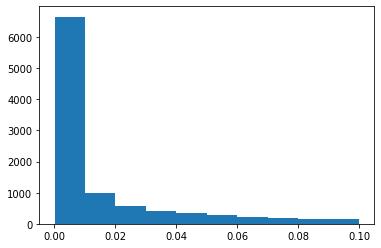

In [118]:
import matplotlib.pyplot as plt
plt.hist(x)

In [119]:
x = randint(3,10).rvs(size=10000)

In [120]:
import matplotlib.pyplot as plt
np.bincount(x)

array([   0,    0,    0, 1408, 1441, 1450, 1398, 1487, 1391, 1425])

In [121]:
# 5:48am start

In [122]:
x = uniform(loc=0.1, scale=0.9).rvs(size=100)

In [123]:
%%time
clf = RandomizedSearchCV(model, {
    "max_depth": randint(1, 10),
    "max_features": randint(2, 15),
    "n_estimators": [200, 400, 800, 1600, 2400],
    "min_impurity_decrease": loguniform(0.00005, 0.05, scale=2),
    "max_samples": uniform(loc=0.1, scale=0.9)
}, cv=None, n_iter=100)
clf.fit(train, train_labels)

/data/ges/miniconda3/envs/erdos_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 163 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 513 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 963 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    8.5s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.6s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=144)]: Done 962 tasks      | elapsed:    1.0s
[Parallel(n_jobs=144)]: Done 1600 out of 1600 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent wo

CPU times: user 29min 54s, sys: 1min 49s, total: 31min 43s
Wall time: 30min 4s


[Parallel(n_jobs=-1)]: Done 114 out of 200 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.7s finished


RandomizedSearchCV(estimator=RandomForestClassifier(max_features='sqrt',
                                                    n_estimators=1600,
                                                    n_jobs=-1, random_state=50,
                                                    verbose=1),
                   n_iter=100,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d9a0be5c0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d9a0be400>,
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d9a05f1d0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d9a0bed68>,
                                        'n_estimators': [200, 400, 800, 1600,
                                                         2400]})

In [125]:
clf.cv_results_

{'mean_fit_time': array([5.31463008, 2.55758224, 2.45070066, 1.36875887, 0.68704948,
        1.42417345, 0.65328841, 6.97535033, 0.63650937, 0.69262557,
        6.70488038, 2.53578548, 4.73084459, 0.626055  , 6.04306593,
        5.05897064, 0.68661156, 2.64234314, 1.40313416, 1.41336169,
        1.3777606 , 2.4790554 , 1.44542828, 6.14818645, 0.62580128,
        2.52888608, 2.48284345, 4.86400828, 0.63076811, 6.00706749,
        2.51194167, 6.14917068, 2.48254728, 2.46830354, 2.54253044,
        2.48252478, 4.40335131, 4.2992732 , 2.70604253, 0.64492202,
        1.38759899, 1.45406027, 0.66033511, 1.44393764, 6.68235507,
        0.63543358, 2.45328274, 2.57937231, 6.17623796, 0.64337258,
        2.62457905, 4.31678495, 1.38130994, 2.49201245, 0.6429543 ,
        0.62800646, 2.55839176, 1.46639466, 6.69469161, 6.71408968,
        0.64262452, 0.63086538, 2.48453064, 6.17200041, 4.36610389,
        0.63690176, 0.62700338, 1.36019044, 1.36707315, 2.57770052,
        6.81266336, 2.59383554,

In [126]:
clf.best_estimator_

RandomForestClassifier(max_depth=7, max_features=12,
                       max_samples=0.321652552514885,
                       min_impurity_decrease=0.0003636835961158246,
                       n_estimators=200, n_jobs=-1, random_state=50, verbose=1)

## Training

In [20]:
# Create the model with 100 trees
model = RandomForestClassifier(
max_depth=7, max_features=12,
                       max_samples=0.321652552514885,
                       min_impurity_decrease=0.0003636835961158246,
                       n_estimators=200,
    random_state=RSEED, 
#                               max_features = 'sqrt',
                              n_jobs=-1, verbose = 1)
# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 out of 200 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished


RandomForestClassifier(max_depth=7, max_features=12,
                       max_samples=0.321652552514885,
                       min_impurity_decrease=0.0003636835961158246,
                       n_estimators=200, n_jobs=-1, random_state=50, verbose=1)

In [22]:
sorted(zip(features, model.feature_importances_), key=(lambda f: f[1]), reverse=True)

[('avg_bbox_speed', 0.16521769846445652),
 ('avg_ego_speed', 0.11771827868468239),
 ('90p_bbox_speed', 0.11244267729146724),
 ('avg_bbox_longevity', 0.10064764297773485),
 ('90p_bbox_longevity', 0.09746350989719343),
 ('90p_num_bboxes', 0.08930489761381324),
 ('90p_bbox_size', 0.08518892122461903),
 ('avg_num_bboxes', 0.08069626510334992),
 ('avg_bbox_size', 0.07545496876394492),
 ('time_of_day__Day', 0.017067724629401263),
 ('location__location_sf', 0.01665245380947993),
 ('time_of_day__Night', 0.01238934797358758),
 ('time_of_day__Dawn/Dusk', 0.011696690361449756),
 ('location__location_phx', 0.009648707447103852),
 ('location__location_other', 0.00841021575771592)]

In [23]:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 28
Average maximum depth 6


In [24]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
print("train score", model.score(train, train_labels))

# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
print("test score", model.score(test, test_labels))

[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 114 out of 200 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=144)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 114 out of 200 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=144)]: Done 200 out of 200 | elapsed:    0.2s finished


train score 0.8585858585858586


[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 114 out of 200 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=144)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 114 out of 200 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=144)]: Done 200 out of 200 | elapsed:    0.2s finished


test score 0.42857142857142855


### Visualize confidence

In [131]:
def get_prediction_dist(model, data):
    return np.array([ind_tree.predict(data) for ind_tree in tqdm(model.estimators_)])

In [132]:
test_predictions = get_prediction_dist(model, test).T

100%|██████████| 200/200 [00:00<00:00, 423.65it/s]


In [133]:
test_preds = {scenario: test_predictions[test.index == scenario] for scenario in test.index.unique()}

In [92]:
plt.figure(figsize=(40, 5))
scenario = "training_0002-S8"
sorted_by_mean = test_preds[scenario][np.argsort(np.mean(test_preds[scenario], axis=1))]
bottom_half = sorted_by_mean[:500].T
top_half = sorted_by_mean[-500:].T
plt.boxplot(bottom_half)
plt.boxplot(top_half)
plt.show()

KeyError: 'training_0002-S8'

<Figure size 2880x360 with 0 Axes>

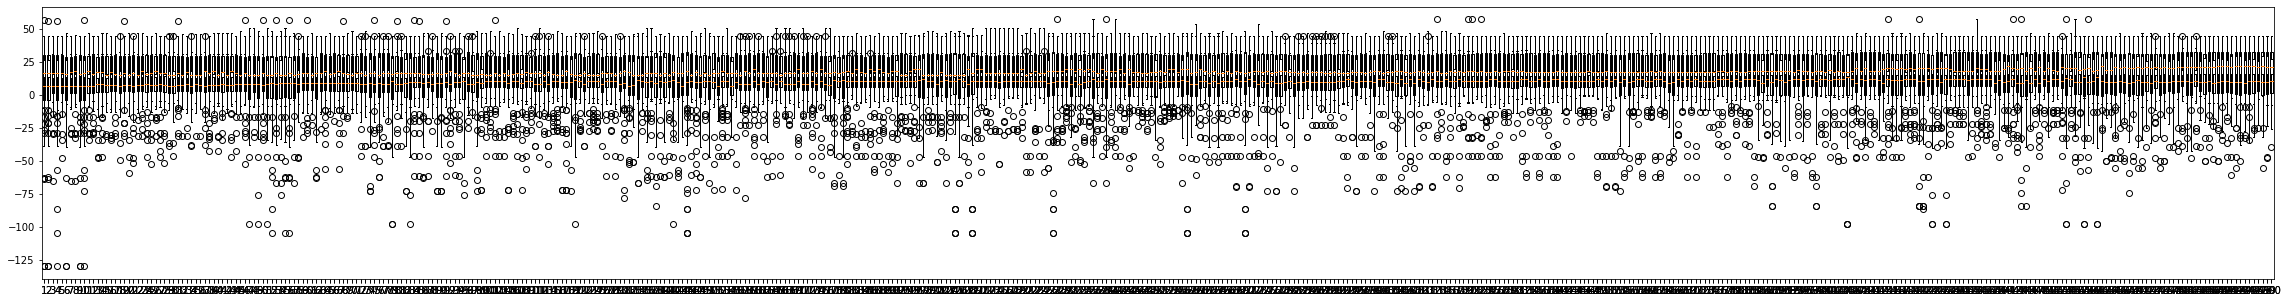

In [356]:
plt.figure(figsize=(40, 5))
scenario = "training_0004-S20"
sorted_by_mean = test_preds[scenario][np.argsort(np.mean(test_preds[scenario], axis=1))]
bottom_half = sorted_by_mean[:500].T
top_half = sorted_by_mean[-500:].T
plt.boxplot(bottom_half)
plt.boxplot(top_half)
# plt.boxplot(np.concatenate([bottom_half, top_half], axis=0))
plt.show()
# plt.boxplot(test_preds["training_0000-S0"][:1000].T)
# sns.ecdfplot(test_preds["training_0000-S0"])

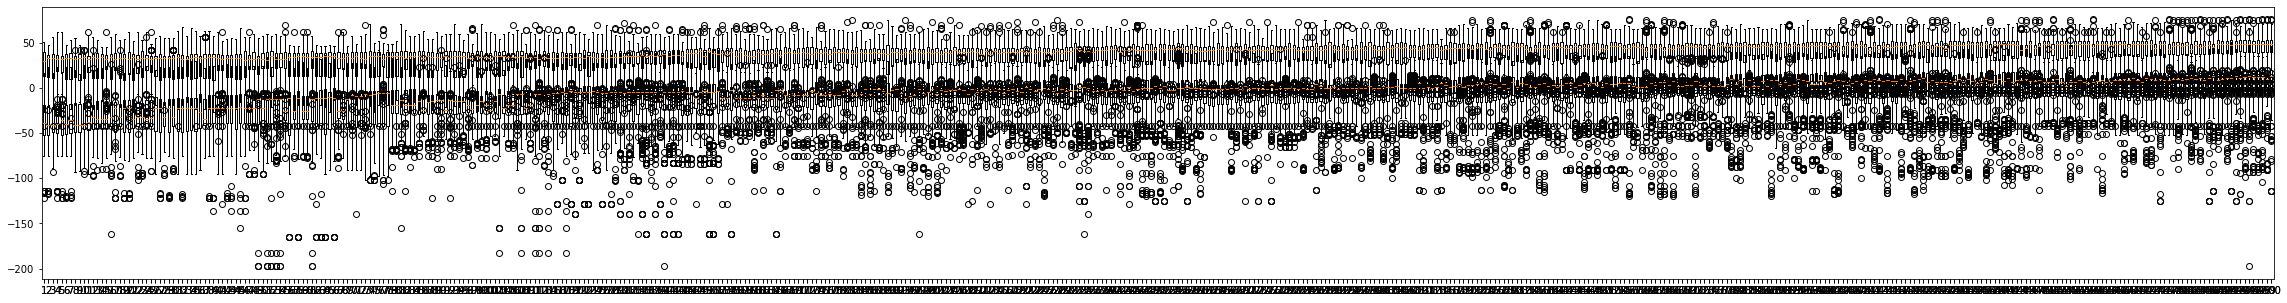

In [357]:
plt.figure(figsize=(40, 5))
scenario = "training_0001-S15"
sorted_by_mean = test_preds[scenario][np.argsort(np.mean(test_preds[scenario], axis=1))]
bottom_half = sorted_by_mean[:500].T
top_half = sorted_by_mean[-500:].T
plt.boxplot(bottom_half)
plt.boxplot(top_half)
# plt.boxplot(np.concatenate([bottom_half, top_half], axis=0))
plt.show()
# plt.boxplot(test_preds["training_0000-S0"][:1000].T)
# sns.ecdfplot(test_preds["training_0000-S0"])

## Using trained model to get best config and saving

In [134]:
train_copy = train.copy()
train_copy["ground_truth"] = train_labels
test_copy = test.copy()
test_copy["ground_truth"] = test_labels

In [135]:
train_copy["prediction"] = model.predict(train)
test_copy["prediction"] = model.predict(test)

[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 114 out of 200 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=144)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 114 out of 200 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=144)]: Done 200 out of 200 | elapsed:    0.1s finished


In [136]:
train.index.unique()

Index(['training_0000-S7', 'training_0000-S8', 'training_0000-S9',
       'training_0001-S0', 'training_0001-S1', 'training_0001-S10',
       'training_0001-S11', 'training_0001-S12', 'training_0001-S13',
       'training_0001-S14', 'training_0001-S15', 'training_0001-S16',
       'training_0001-S17', 'training_0001-S18', 'training_0001-S19',
       'training_0001-S2', 'training_0001-S20', 'training_0001-S21',
       'training_0001-S22', 'training_0001-S23', 'training_0001-S3',
       'training_0001-S4', 'training_0001-S5', 'training_0001-S6',
       'training_0001-S7', 'training_0001-S8', 'training_0001-S9',
       'training_0002-S0', 'training_0002-S1', 'training_0002-S10',
       'training_0002-S11', 'training_0002-S12', 'training_0002-S13',
       'training_0002-S14', 'training_0002-S15', 'training_0002-S16',
       'training_0002-S17', 'training_0002-S18', 'training_0002-S19',
       'training_0002-S2', 'training_0002-S20', 'training_0002-S21',
       'training_0002-S22', 'trainin

In [138]:
test.index.unique()

Index(['training_0000-S0', 'training_0000-S1', 'training_0000-S10',
       'training_0000-S11', 'training_0000-S12', 'training_0000-S13',
       'training_0000-S14', 'training_0000-S15', 'training_0000-S16',
       'training_0000-S17', 'training_0000-S18', 'training_0000-S19',
       'training_0000-S2', 'training_0000-S20', 'training_0000-S21',
       'training_0000-S22', 'training_0000-S23', 'training_0000-S3',
       'training_0000-S4', 'training_0000-S5', 'training_0000-S6',
       'training_0002-S24', 'training_0002-S4', 'training_0002-S6',
       'training_0002-S9', 'training_0003-S1', 'training_0003-S11',
       'training_0003-S14', 'training_0003-S16', 'training_0003-S18',
       'training_0003-S20', 'training_0003-S22', 'training_0003-S24',
       'training_0003-S5', 'training_0003-S7', 'training_0003-S9',
       'training_0004-S1', 'training_0004-S12', 'training_0004-S14',
       'training_0004-S16', 'training_0004-S19', 'training_0004-S20',
       'training_0004-S22', 'traini

In [143]:
train_copy["run_name"] = train_copy.index
test_copy["run_name"] = test_copy.index

In [144]:
to_predict = test_copy

In [150]:
import json
learned_policy = {run: json.loads(label_list[label_index]) for (run, label_index) in zip(to_predict["run_name"], to_predict["prediction"])}
learned_policy

{'training_0000-S0': {'D-model': 'efficientdet-d4',
  'D-conf': 0.3,
  'D-seq-pol': 'wait',
  'T-min-iou': 0.1,
  'T-max-age': 7,
  'T-every-nth-det': 1},
 'training_0000-S1': {'D-model': 'efficientdet-d7x',
  'D-conf': 0.5,
  'D-seq-pol': 'eager',
  'T-min-iou': 0.1,
  'T-max-age': 7,
  'T-every-nth-det': 1},
 'training_0000-S10': {'D-model': 'efficientdet-d4',
  'D-conf': 0.3,
  'D-seq-pol': 'tail-aware',
  'T-min-iou': 0.1,
  'T-max-age': 1,
  'T-every-nth-det': 1},
 'training_0000-S11': {'D-model': 'efficientdet-d7x',
  'D-conf': 0.5,
  'D-seq-pol': 'wait',
  'T-min-iou': 0.1,
  'T-max-age': 3,
  'T-every-nth-det': 1},
 'training_0000-S12': {'D-model': 'efficientdet-d4',
  'D-conf': 0.3,
  'D-seq-pol': 'tail-aware',
  'T-min-iou': 0.1,
  'T-max-age': 1,
  'T-every-nth-det': 1},
 'training_0000-S13': {'D-model': 'efficientdet-d7x',
  'D-conf': 0.5,
  'D-seq-pol': 'eager',
  'T-min-iou': 0.1,
  'T-max-age': 7,
  'T-every-nth-det': 1},
 'training_0000-S14': {'D-model': 'efficientdet-d

In [151]:
import pickle
with open("RF_condensed_space_k_10.pl", 'wb') as f:
    pickle.dump(learned_policy, f)